### Model Training (3 Parts/Models)

Import packages and Load Data

In [1]:
# import packages for training
import pandas as pd
import numpy as np # Good to have for ML tasks
import os # Import the os module
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score # Use later for evaluation

In [2]:
# Define the base path components
base_project_folder = r"C:\Users\comat\GitProjects\customer-churn-ai" # Raw string is fine here
data_subfolder = "data"
training_input_subfolder_name = "training_input"

# Construct the path to the 'training_input' directory robustly
training_input_path = os.path.join(base_project_folder, data_subfolder, training_input_subfolder_name)

# Define full file paths using os.path.join(). (these should match what you saved them as)
x_train_path = os.path.join(training_input_path, "X_train.parquet")
x_test_path = os.path.join(training_input_path, "X_test.parquet")
y_train_path = os.path.join(training_input_path, "y_train.parquet")
y_test_path = os.path.join(training_input_path, "y_test.parquet")

try:
    # Load DataFrames (X_train, X_test)
    X_train = pd.read_parquet(x_train_path)
    X_test = pd.read_parquet(x_test_path)
    print(f"X_train loaded successfully. Shape: {X_train.shape}")
    print(f"X_test loaded successfully. Shape: {X_test.shape}")

    # Load y_train and y_test (they were saved as DataFrames with a 'Churn' column)
    y_train_df = pd.read_parquet(y_train_path)
    y_test_df = pd.read_parquet(y_test_path)

    # Convert y_train and y_test back to Pandas Series for scikit-learn
    if 'Churn' in y_train_df.columns and 'Churn' in y_test_df.columns:
        y_train = y_train_df['Churn']
        y_test = y_test_df['Churn']
        print(f"\ny_train loaded successfully. Shape: {y_train.shape}")
        print(f"y_test loaded successfully. Shape: {y_test.shape}")
        print("\nAll datasets loaded and y_train/y_test converted to Series.")
    else:
        print("Error: 'Churn' column not found in loaded y_train_df or y_test_df.")
        # Handle error or stop if target is not loaded correctly

except FileNotFoundError:
    print(f"Error: One or more Parquet files not found. Please check paths:")
    print(f"  X_train expected at: {x_train_path}")
    print(f"  X_test expected at: {x_test_path}")
    print(f"  y_train expected at: {y_train_path}")
    print(f"  y_test expected at: {y_test_path}")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

X_train loaded successfully. Shape: (5634, 32)
X_test loaded successfully. Shape: (1409, 32)

y_train loaded successfully. Shape: (5634,)
y_test loaded successfully. Shape: (1409,)

All datasets loaded and y_train/y_test converted to Series.


In [3]:
# Display the head of X_train and first 5 of y_train to verify
print("\nHead of X_train:")
print(X_train.head())
print("\nHead of y_train:")
print(y_train.head())


Head of X_train:
   SeniorCitizen  MonthlyCharges  TotalCharges    HF_neg    HF_nue    HF_pos  \
0              0       -0.521976     -0.263871 -0.596856 -0.608280  0.631591   
1              0        0.337478     -0.505423 -0.594176  0.155381  0.535430   
2              0       -0.809013     -0.751850 -0.578528  2.236056  0.265643   
3              0        0.284384     -0.174271 -0.599526 -0.571609  0.629585   
4              0       -0.676279     -0.991514 -0.595537 -0.536079  0.621505   

   gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  ...  \
0         True        False           False             False  ...   
1         True         True            True              True  ...   
2         True         True            True             False  ...   
3        False         True           False              True  ...   
4         True         True            True              True  ...   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0   

---
#### Model 1: Train Logistic Regression Model
Initialize Logistic Regression Model and Train the Model

In [4]:
# 1. Initialize the Logistic Regression Model
# Begin with mostly default parameters. `liblinear` solver used for binary classification and small datasets.
# `random_state` used for reproducibility of results if solver involves randomness.
# `max_iter` set to 1000 to ensure convergence for complex datasets. default is 100.
log_reg_model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
print("Logistic Regression model initialized with solver='liblinear' and max_iter=1000.")

# 2. Fit/Train the model using the training data.
print("\nTraining the Logistic Regression model...")
log_reg_model.fit(X_train, y_train)
print("Logistic Regression model trained successfully!")

Logistic Regression model initialized with solver='liblinear' and max_iter=1000.

Training the Logistic Regression model...
Logistic Regression model trained successfully!


In [5]:
# QUICK Check on training accuracy [NOT a substitute for test set evaluation!]
# This just tells us how well the model fits the data it learned from.
y_train_pred_log_reg = log_reg_model.predict(X_train)
train_accuracy_log_reg = accuracy_score(y_train, y_train_pred_log_reg)
print(f"Quick check: Training Accuracy for Logistic Regression: {train_accuracy_log_reg:.4f}")

Quick check: Training Accuracy for Logistic Regression: 1.0000


---
#### Insights / Notes: Logistic Regression
* Training accuracy is 1.0, which means the model learned the data so well that it makes no mistakes. This is not necessarily good.  

* **Potential Implications**:
    * **Overfitting**:
        - *Definition*: when a machine learning model learns the training data too specifically, capturing not only the underlying patterns but also the noise and random fluctuations unique to that particular set of data.
        - *Result*: model becomes very good at predicting the data it has already seen but performs poorly when it encouter new, unseen data (which will be X_test). This is an issue because an overfit model has poor generization, which is the goal of a predictive model, and will lead to misleading sense of real-world performance.
        * *Analogy*:
            * Overfitting is like a student who has memorized the exact answers to every single question in the practice textbook (X_train, y_train), so they can ace any test that uses those exact questions.
            * However, if the actual exam (X_test, y_test) has slightly different questions or new scenarios (even if based on the same overall subject), the student who only memorized will struggle because they didn't learn the underlying concepts needed to solve new problems.
            * We want a student (model) who learns the concepts well enough to perform well on both practice questions and the real exam.  

* **Plan**:
    * Test log_reg_model on X_test and y_test data, which it hasn't seen before.
    * Train Other Models like Random Forest and an XGBoost model. They may behave differently on the training so I can compare their results. Choose one that generalizes best  
    
---

#### Model 2: Train Random Forest Model

In [6]:
from sklearn.ensemble import RandomForestClassifier

# 1. Initialize the Random Forest Classifier model
# Start with common default values; set a random_state for reproducibility.
# n_estimators is the number of trees in the forest. n_jobs=-1 uses all available CPU cores for training to boost speed.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("Random Forest Classifier model initialized with n_estimators=100 and n_jobs=-1")

# 2. Fit/Train the model using the training data.
print("\nTraining the Random Forest Regression model...(get comfy)")
rf_model.fit(X_train, y_train)
print("Random Forest model trained successfully!")

Random Forest Classifier model initialized with n_estimators=100 and n_jobs=-1

Training the Random Forest Regression model...(get comfy)
Random Forest model trained successfully!


In [7]:
# QUICK Check on training accuracy [NOT a substitute for test set evaluation!]
# This just tells us how well the model fits the data it learned from.
try:
    y_train_pred_rf = rf_model.predict(X_train)
    train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
    print(f"\nQuick check: Training Accuracy for Random Forest: {train_accuracy_rf:.4f}")
except Exception as e:
    print(f"Could not calculate training score: {e}")


Quick check: Training Accuracy for Random Forest: 1.0000


---
#### Insights / Notes: Random Forest
- Training accuracy is 1.0, which means the model learned the X_train data so well that it makes no mistakes when predicting y_train.
- While this shows the model has high capacity to learn, it doesn't tell us how well it will perform on new, unseen data. The primary concern remains overfitting.

* **Potential Implications**:
    * *Model Complexity*: Random Forests are powerful ensemble models. By default, each of the 100 decision trees in your forest can grow quite deep and complex. Individual trees can become very good at fitting (even "memorizing") the specific portion of the data they are trained on.
    * *Ensemble Effect*: When you have 100 trees voting, if many of them have perfectly learned their part of the training data, the overall ensemble can easily achieve perfect accuracy on that same training data.
    * Potential Overfittiing  
  
* **Analogy** (Revisiting our Student Analogy):
    * If Logistic Regression was like one student who memorized the practice test answers, your Random Forest is like an entire study group where each member memorized a different section of the practice textbook or different versions of practice questions.
        * When they collaborate (the "ensemble" of trees), they can collectively answer every single question from those practice materials perfectly.
        * However, the real test is the final exam (X_test), which will have questions they haven't seen before. Their ability to generalize their knowledge, rather than just recall memorized answers, will be tested then.

* **Plan**:
    * Train XGBoost, Evaluate all models, then Test log_reg_model, rf_model, and xgb_model on X_test and y_test data, which they haveb't seen before.  
    * Test Set Evaluation is Key: The performance on X_test (on Day 7) will be the true indicator of how well this Random Forest model generalizes. We'll compare its training accuracy to its testing accuracy. A large drop would confirm overfitting.
    * Hyperparameter Tuning (Later): If we find that the Random Forest is overfitting (i.e., high training accuracy, much lower test accuracy), we can later tune its hyperparameters. For Random Forest, common parameters to adjust to reduce overfitting include:
        * max_depth (limiting how deep each tree can grow)
        * min_samples_split (requiring more samples to split a node)
        * min_samples_leaf (requiring more samples to be at a leaf node)
        * n_estimators (number of trees – sometimes more trees can help, but other times a very large number with overly complex individual trees might still overfit).
        * This tuning helps simplify the model and encourage it to learn more general patterns
---

#### Model 3: Train XGBoost Model

In [8]:
from xgboost import XGBClassifier

# 1. Initialize the XGBoost Classifier model
# We'll set a random_state for reproducibility.
# For binary classification, specify objective with 'binary:logistic'.
# eval_metric can be set to 'logloss' or 'auc' for classification.
xgb_model = XGBClassifier(objective='binary:logistic',
                          eval_metric='logloss',    # A common metric for binary classification
                          random_state=42)

print("XGBoost model initialized.")

# 2. Fit/Train the model using the training data.
print("\nTraining the XGBoost model... (This might also take a moment)")
xgb_model.fit(X_train, y_train)
print("XGBoost model trained successfully!")

XGBoost model initialized.

Training the XGBoost model... (This might also take a moment)
XGBoost model trained successfully!


In [9]:
# QUICK Check on training accuracy [NOT a substitute for test set evaluation!]
# This just tells us how well the model fits the data it learned from.
try:
    y_train_pred_xgb = xgb_model.predict(X_train)
    train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
    print(f"\nQuick check: Training Accuracy for XGBoost: {train_accuracy_xgb:.4f}")
except Exception as e:
    print(f"Could not calculate training score: {e}")


Quick check: Training Accuracy for XGBoost: 1.0000


---
#### Insights / Notes: XGBoost
- Training accuracy is 1.0, which means the model learned the X_train data so well that it makes no mistakes when predicting y_train.
- While this shows the model has high capacity to learn, it doesn't tell us how well it will perform on new, unseen data. The primary concern remains overfitting.


* **Potential Implications**:
    * *Overfitting* is the Recurring Theme.
        * The model might have "memorized" the training data rather than learning generalizable patterns that would apply to new customers.
* **Relevance/Importance**: If the model is overfit, its real-world performance (when predicting churn for new customers or on your test set) will likely be significantly lower than this perfect training score.

* **Plan**:
    - Move to Day 7 and evaluate models on Test Data to measure generalization performance.
    - Evaluate models using F1, AUC, confusion matrix  

    * Parameter Tuning (Later): XGBoost has regularization parameters (like lambda for L2, alpha for L1, max_depth, learning_rate, subsample, colsample_bytree) that can be tuned later to combat overfitting if the test set performance indicates it's a problem.
---
---
---

### Day 7: Model Evaluation

---
#### 7.1 Evaluate Logistic Regression Model

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [11]:
# 1. Make predictions on the test set
print("\nEvaluating Logistic Regression model...")
y_pred_log_reg = log_reg_model.predict(X_test)

# For AUC, we need probability scores for the positive class (Churn=1)
y_pred_proba_log_reg = log_reg_model.predict_proba(X_test)[:, 1]

# 2. Calculate Eval Metrics
accuracy_lr = accuracy_score(y_test, y_pred_log_reg)
precision_lr = precision_score(y_test, y_pred_log_reg)
recall_lr = recall_score(y_test, y_pred_log_reg)
f1_lr = f1_score(y_test, y_pred_log_reg)
auc_lr = roc_auc_score(y_test, y_pred_proba_log_reg)

# 3. Print Evaluation Metrics
print("\n--- Logistic Regression Metrics ---")
print(f"Accuracy:  {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall:    {recall_lr:.4f}")
print(f"F1-Score:  {f1_lr:.4f}")
print(f"AUC:       {auc_lr:.4f}")

# 4. Display Confusion Matrix
print("\nConfusion Matrix (Logistic Regression):")
cm_lr = confusion_matrix(y_test, y_pred_log_reg)
print(cm_lr)

# 5. Display Classification Report (provides precision, recall, f1-score per class)
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_log_reg, target_names=['No Churn (0)', 'Churn (1)']))



Evaluating Logistic Regression model...

--- Logistic Regression Metrics ---
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
AUC:       1.0000

Confusion Matrix (Logistic Regression):
[[1035    0]
 [   0  374]]

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

No Churn (0)       1.00      1.00      1.00      1035
   Churn (1)       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



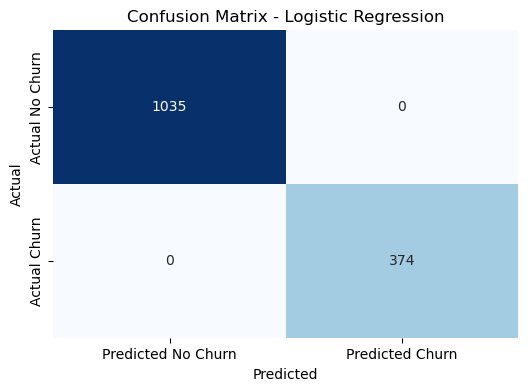

In [12]:
# For a more visual display of the confusion matrix (optional, but nice):
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### **Observations**:
* Showing perfect scores across the board, which is not realistic. Human behavior is unpredicatable, so perfect prediction is not likely. I was aiming for above 0.7.
* **Data Leakage** - most likely cause. Some informatin abot the target variable `Churn  has inadvertently "leaked" into my feature set (X_train and X_test). I don't think the model is learning to predict, I think it has the answers.
* **Investigating Leakage**:
    * Is there a feature in df_model_ready that is providing the Churn answer?
        * ***MOST DIRECT CHECK*** is to look at the correlation between features and the Churn target variable.
        * If any feature has a correlation of +1 or -1 (or extremely close to it) with Churn, that's a very strong sign of leakage or that the feature is a direct proxy for the target.  

* See notebook day-6-7-data_leakage.ipynb


---
#### 7.2 Evaluate Random Forest Model

In [ ]:
# 1. Make predictions on the test set
print("\nEvaluating Random Forest model...")
y_pred_rf = rf_model.predict(X_test)

---
#### 7.3 Evaluate XGBoost Model

In [ ]:
# 1. Make predictions on the test set
print("\nEvaluating XGBoost model...")
y_pred_xgb = xgb_model.predict(X_test)